<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

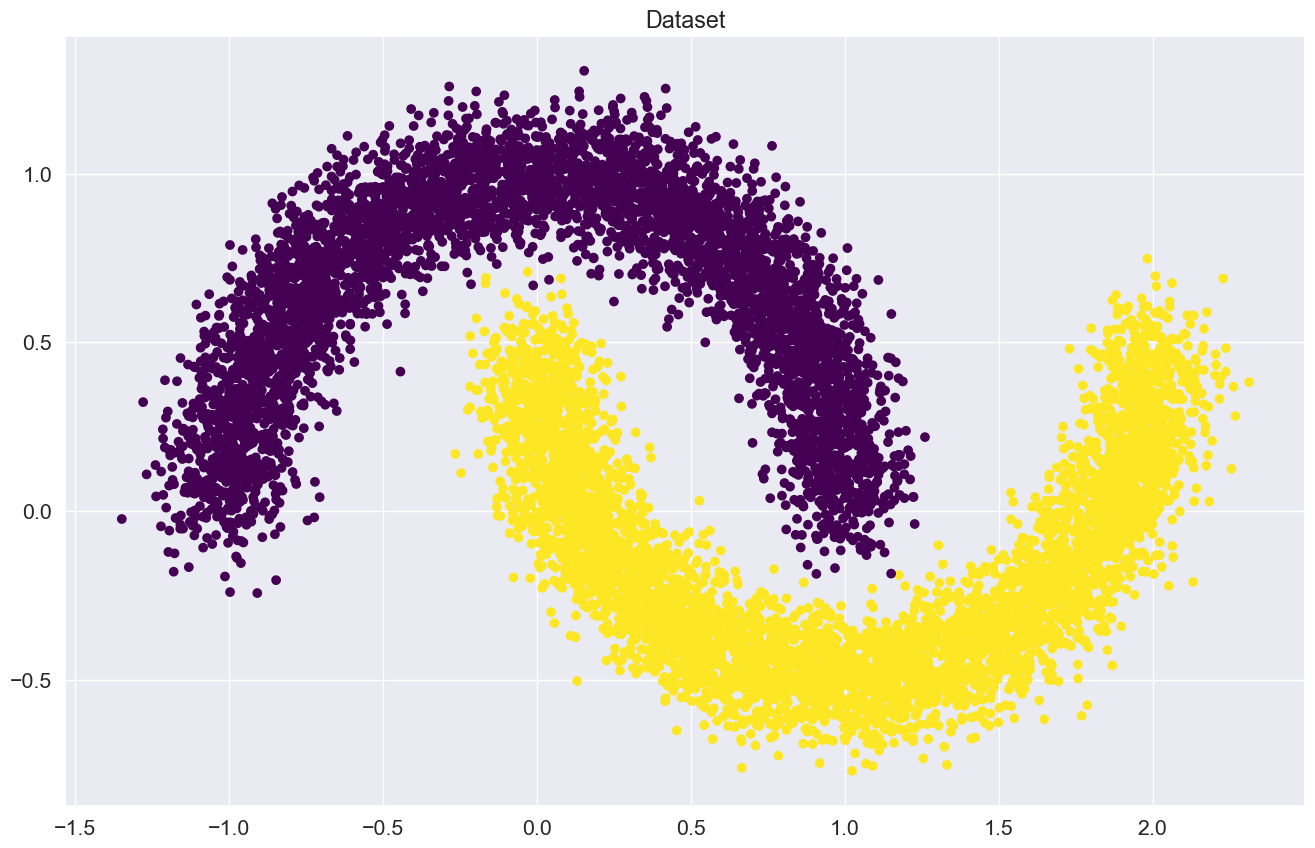

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")  # type: ignore
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t = torch.from_numpy(X_train).type(torch.float32)  # YOUR CODE GOES HERE
y_train_t = torch.from_numpy(y_train).type(torch.float32)  # YOUR CODE GOES HERE
X_val_t = torch.from_numpy(X_val).type(torch.float32)  # YOUR CODE GOES HERE
y_val_t = torch.from_numpy(y_val).type(torch.float32)  # YOUR CODE GOES HERE

Создаем `Dataset` и `DataLoader`.

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [7]:
y_train_t.shape

torch.Size([7500])

In [8]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(size=(1, in_features), dtype=torch.float32))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(
                torch.randn(size=(out_features,), dtype=torch.float32)
            )  # YOUR CODE GOES HERE

    def forward(self, x):
        x = torch.matmul(x, self.weights.T).view(-1)  # YOUR CODE GOES HERE
        if self.bias:
            x += self.bias_term  # YOUR CODE GOES HERE
        return x

In [9]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [10]:
# YOUR CODE
import torchinfo

torchinfo.summary(LinearRegression(2, 1), input_size=(128, 2))

Layer (type:depth-idx)                   Output Shape              Param #
LinearRegression                         [128]                     3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

**Ответ:** 3 переменных.

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [11]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)  # YOUR CODE. Use linear_regression to get outputs
        loss = loss_function(outp, y_batch)  # YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)  # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(
                f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations."
            )
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.359375
Iteration: 100
Batch accuracy: 0.859375
Iteration: 200
Batch accuracy: 0.8671875
Iteration: 300
Batch accuracy: 0.9140625
Iteration: 400
Batch accuracy: 0.8984375
Iteration: 500
Batch accuracy: 0.9140625

Iteration: 582.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ: 755**

### Визуализируем результаты

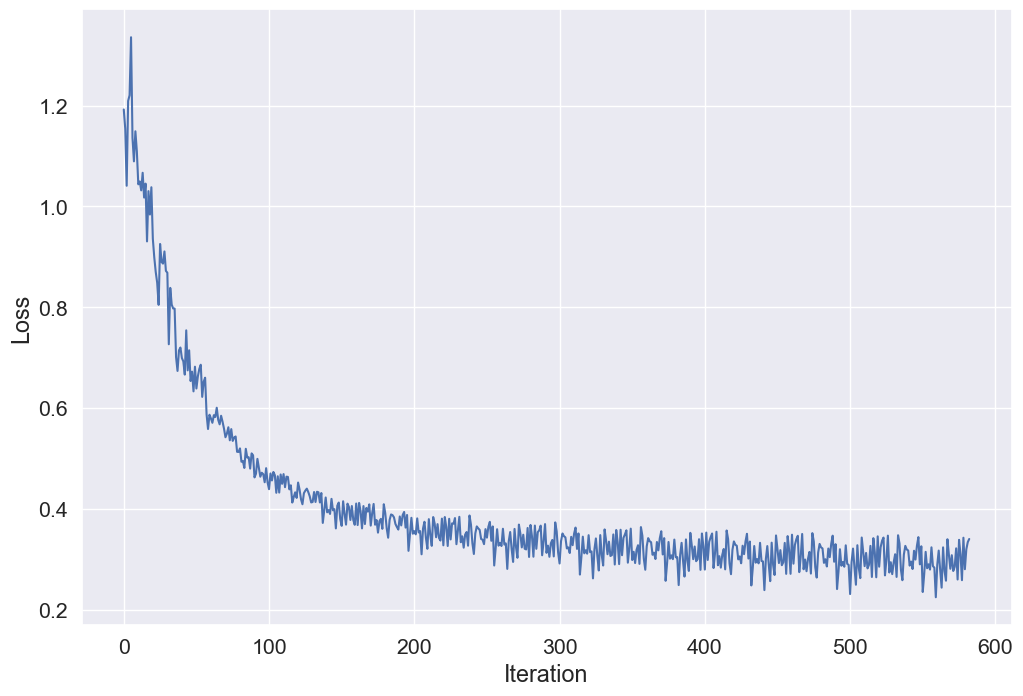

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

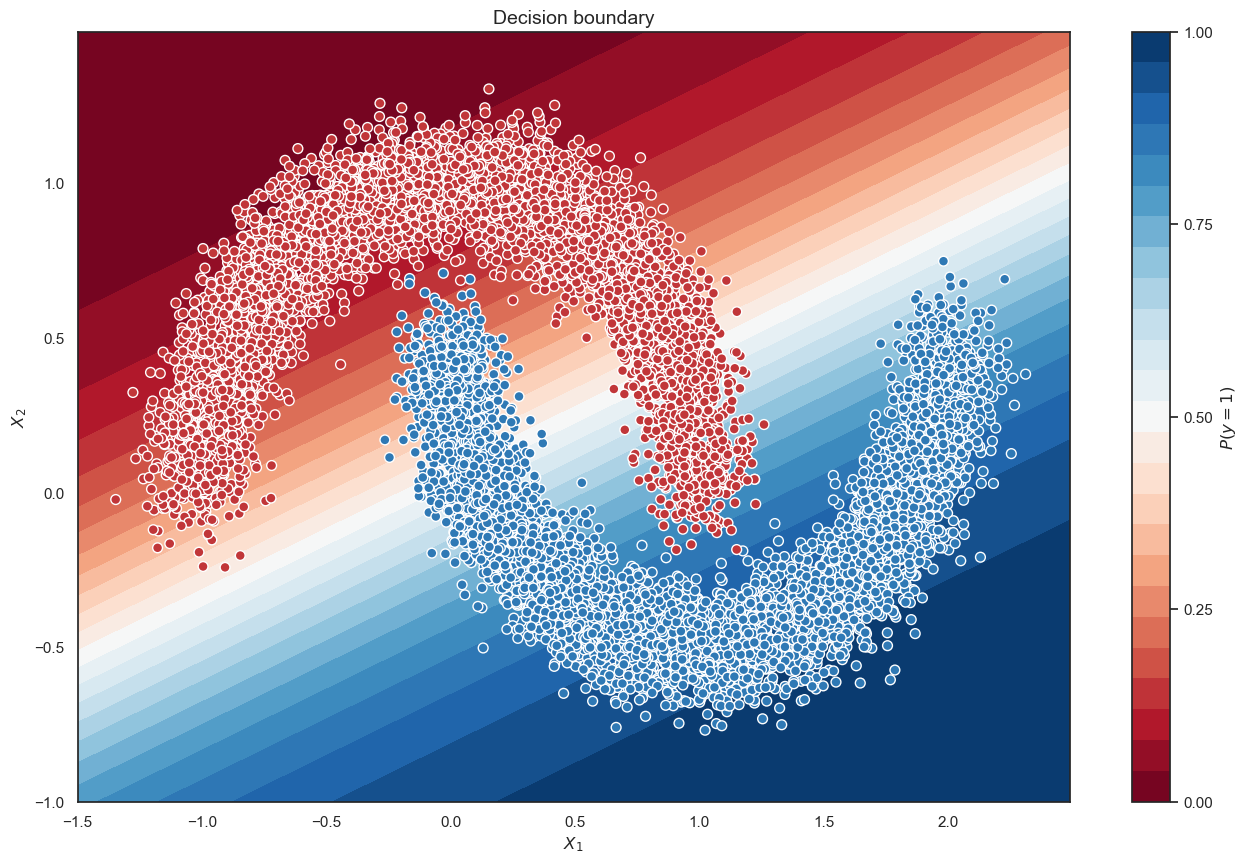

In [13]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:0.01, -1.0:1.5:0.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])

ax.scatter(
    X[100:, 0],
    X[100:, 1],
    c=y[100:],
    s=50,
    cmap="RdBu",
    vmin=-0.2,
    vmax=1.2,
    edgecolor="white",
    linewidth=1,
)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [14]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        # <YOUR CODE>
        output = torch.sigmoid(model(x_batch))
        preds = output.round().type(torch.int32)  # YOUR CODE. Compute predictions
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [15]:
from sklearn.metrics import accuracy_score

# YOUR CODE. Compute total accuracy
accuracy_score(y_val, predict(val_dataloader, linear_regression))

0.8764

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ: 0.8676**

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [16]:
from torchvision.datasets import MNIST
from torchvision import transforms as tfs
from torchvision.transforms import v2


data_tfs = tfs.Compose(
    [
        tfs.ToTensor(),
        tfs.Normalize((0.5), (0.5)),
    ]
)

# install for train and test
root = "./data/homework_04/"
train_dataset = MNIST(
    root, train=True, transform=data_tfs, target_transform=v2.ToDtype(torch.float), download=True
)
val_dataset = MNIST(
    root, train=False, transform=data_tfs, target_transform=v2.ToDtype(torch.float), download=True
)

BATCH_SIZE = 128
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, num_workers=4
)  # YOUR CODE GOES HERE
valid_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, num_workers=4
)  # YOUR CODE GOES HERE

In [17]:
val_dataset.targets.dtype

torch.int64

In [18]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if "cuda" in str(device):
    torch.cuda.empty_cache()


def move_to_device(x, y):
    return x.to(device), y.to(device)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, move_to_device)
valid_dataloader = WrappedDataLoader(valid_dataloader, move_to_device)


## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [19]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [20]:
activation = nn.ELU



model = nn.Sequential(

    nn.Flatten(),

    # YOUR CODE. Add layers to your sequential class
    nn.Linear(28 * 28, 128),
    activation(),
    nn.Linear(128, 10),

)
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=10, bias=True)
)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [23]:
def train_model(
    model: nn.Module,
    loaders: dict[str, DataLoader] | dict[str, WrappedDataLoader],
    criterion: nn.modules.loss._Loss,
    optimizer: torch.optim.Optimizer,
    max_epochs: int = 10,
    verbose=True,
) -> dict[str, list[float]]:
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in (pbar := tqdm(dataloader, total=len(dataloader), leave=False)):
                pbar.set_description(f"Epoch {epoch + 1}, {k} phase")
                if k == "train":
                    # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
                else:
                    # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                    with torch.no_grad():
                        model.eval()
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()  # YOUR CODE GOES HERE
                all = y_batch.size(0)  # YOUR CODE GOES HERE
                epoch_correct += correct.item()
                epoch_all += all
            if verbose:
                if k == "train":
                    print(f"Epoch: {epoch+1}")
                    print("=" * 10)
                print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct / epoch_all)
    return accuracy

In [24]:
accuracy = train_model(model, loaders, criterion, optimizer, 10)

Epoch: 1
Loader: train. Accuracy: 0.8739166666666667


Loader: valid. Accuracy: 0.9175


Epoch: 2
Loader: train. Accuracy: 0.9285833333333333


Loader: valid. Accuracy: 0.9422


Epoch: 3
Loader: train. Accuracy: 0.94985


Loader: valid. Accuracy: 0.9534


Epoch: 4
Loader: train. Accuracy: 0.9614333333333334


Loader: valid. Accuracy: 0.9587


Epoch: 5
Loader: train. Accuracy: 0.9688833333333333


Loader: valid. Accuracy: 0.96


Epoch: 6
Loader: train. Accuracy: 0.9740833333333333


Loader: valid. Accuracy: 0.9622


Epoch: 7
Loader: train. Accuracy: 0.9778333333333333


Loader: valid. Accuracy: 0.967


Epoch: 8
Loader: train. Accuracy: 0.9811


Loader: valid. Accuracy: 0.9685


Epoch: 9
Loader: train. Accuracy: 0.9836333333333334


Loader: valid. Accuracy: 0.9687


Epoch: 10
Loader: train. Accuracy: 0.98585


Loader: valid. Accuracy: 0.9693


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [25]:
elu_accuracy = accuracy["valid"]

In [26]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)


def test_activation_function(activation):
    # YOUR CODE
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    if "cuda" in str(device):
        torch.cuda.empty_cache()

    model = nn.Sequential(
        nn.Flatten(),
        # YOUR CODE. Add layers to your sequential class
        nn.Linear(28 * 28, 128),
        activation(),
        nn.Linear(128, 10),
    )
    model.to(device)

    accuracy = train_model(
        model,
        loaders={"train": train_dataloader, "valid": valid_dataloader},
        criterion=nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(model.parameters()),
        max_epochs=10,
        verbose=False,
    )
    return accuracy

In [27]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)  # YOUR CODE
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)  # YOUR CODE

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

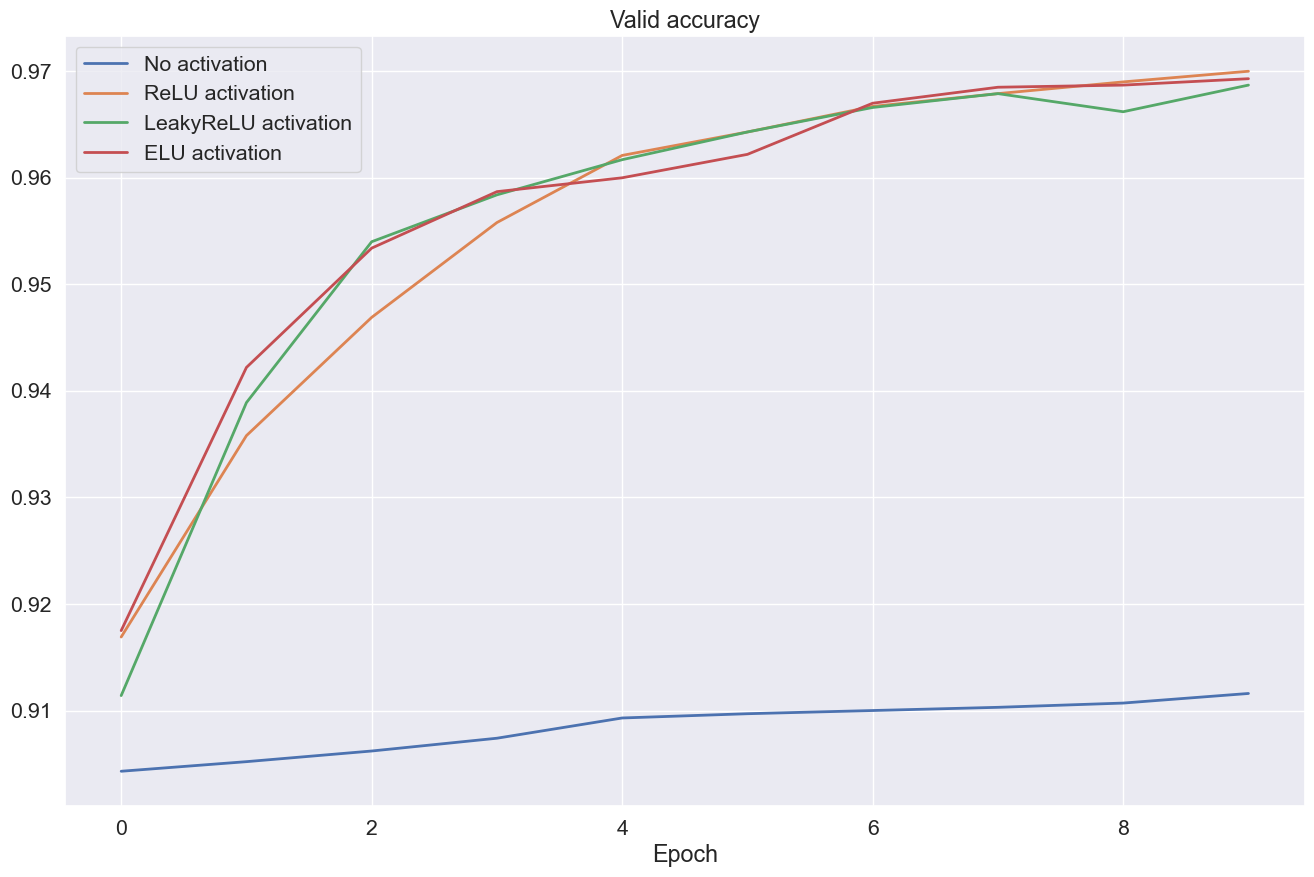

In [31]:
sns.set(style="darkgrid", font_scale=1.4)

max_epochs = 10
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy["valid"], label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy["valid"], label="ReLU activation", linewidth=2)
plt.plot(
    range(max_epochs), leaky_relu_accuracy["valid"], label="LeakyReLU activation", linewidth=2
)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

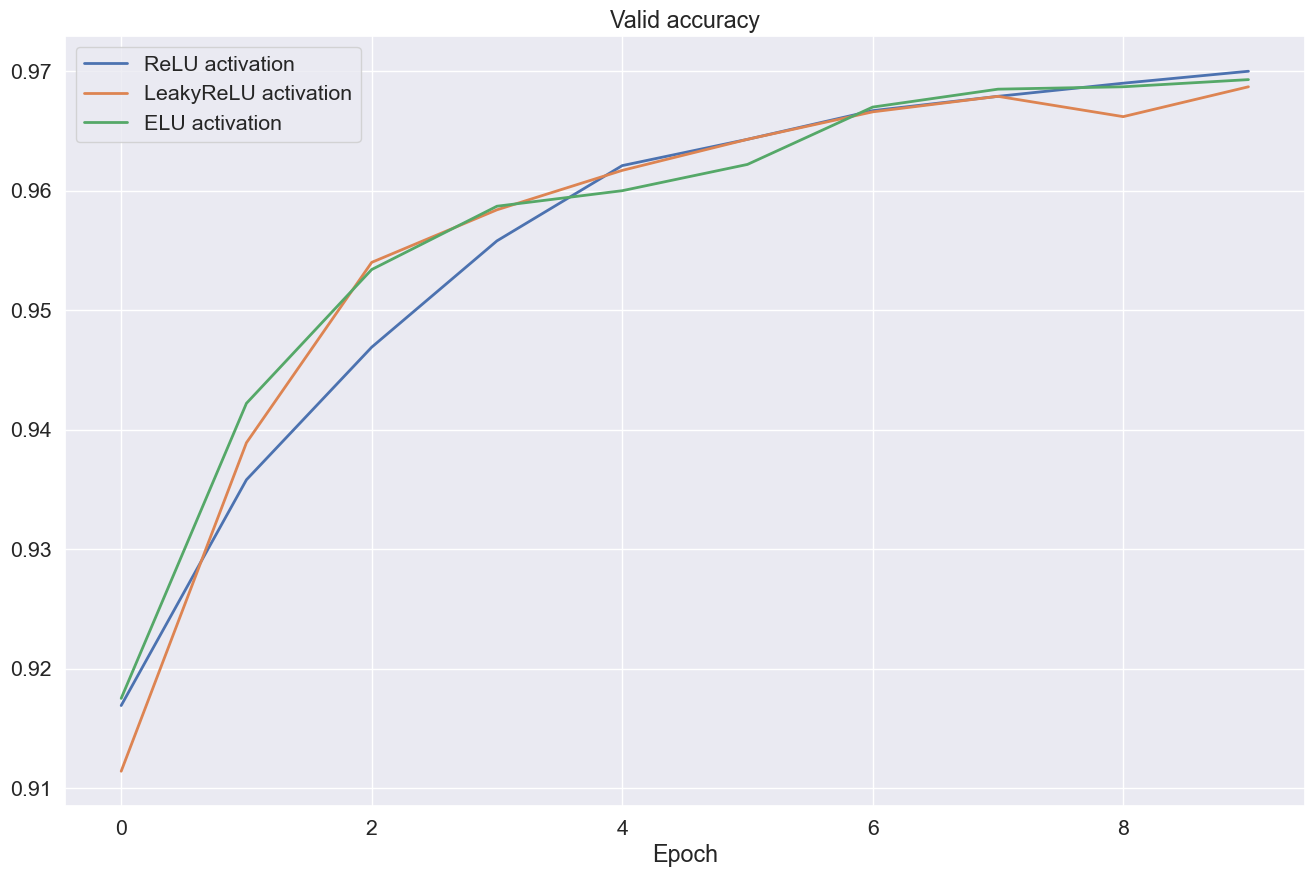

In [32]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy["valid"], label="ReLU activation", linewidth=2)
plt.plot(
    range(max_epochs), leaky_relu_accuracy["valid"], label="LeakyReLU activation", linewidth=2
)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [33]:
# !wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

In [34]:
import cv2
from urllib.request import urlopen


image = np.asarray(
    bytearray(
        urlopen(
            "https://img.the-village.kz/the-village.com.kz/"
            "post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg"
        ).read()
    ),
    dtype="uint8",
)
img = cv2.imdecode(image, cv2.IMREAD_COLOR)  # The image object

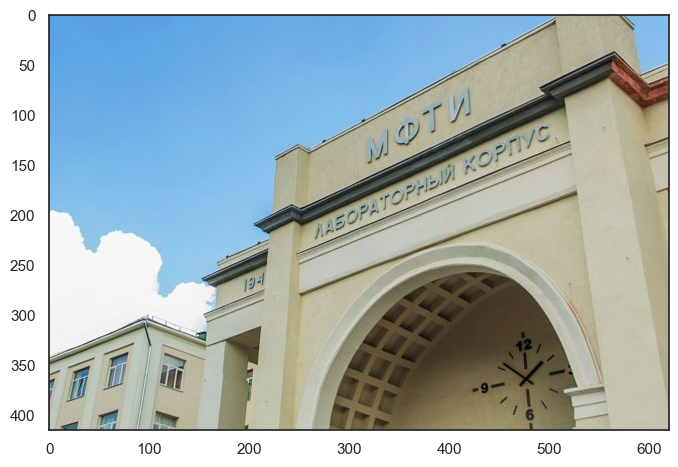

In [35]:
sns.set(style="white")
# img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [36]:
convolutions = {
    k: v.reshape(1, 1, 3, 3).type(torch.float32).repeat(3, 3, 1, 1)
    for k, v in {
        "А": torch.tensor([[0, 0, 0], [0, 1, 0], [0, 0, 0]]),
        "Б": torch.tensor([[0, 2, 0], [0, -2, 0], [0, 1, 0]]),
        "В": torch.tensor([[0, 0, 0], [1, -2, 1], [0, 0, 0]]),
        "Г": torch.tensor([[0, 1, 0], [1, -4, 1], [0, 1, 0]]),
        "Д": torch.tensor([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]),
        "Е": torch.tensor([[0.0625, 0.125, 0.0625], [0.125, 0.25, 0.125], [0.0625, 0.125, 0.0625]]),
    }.items()
}

In [37]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
# kernel = torch.tensor([[0, 0, 0], [1, -2, 1], [0, 0, 0]]).reshape(1, 1, 3, 3).type(torch.float32)

# kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


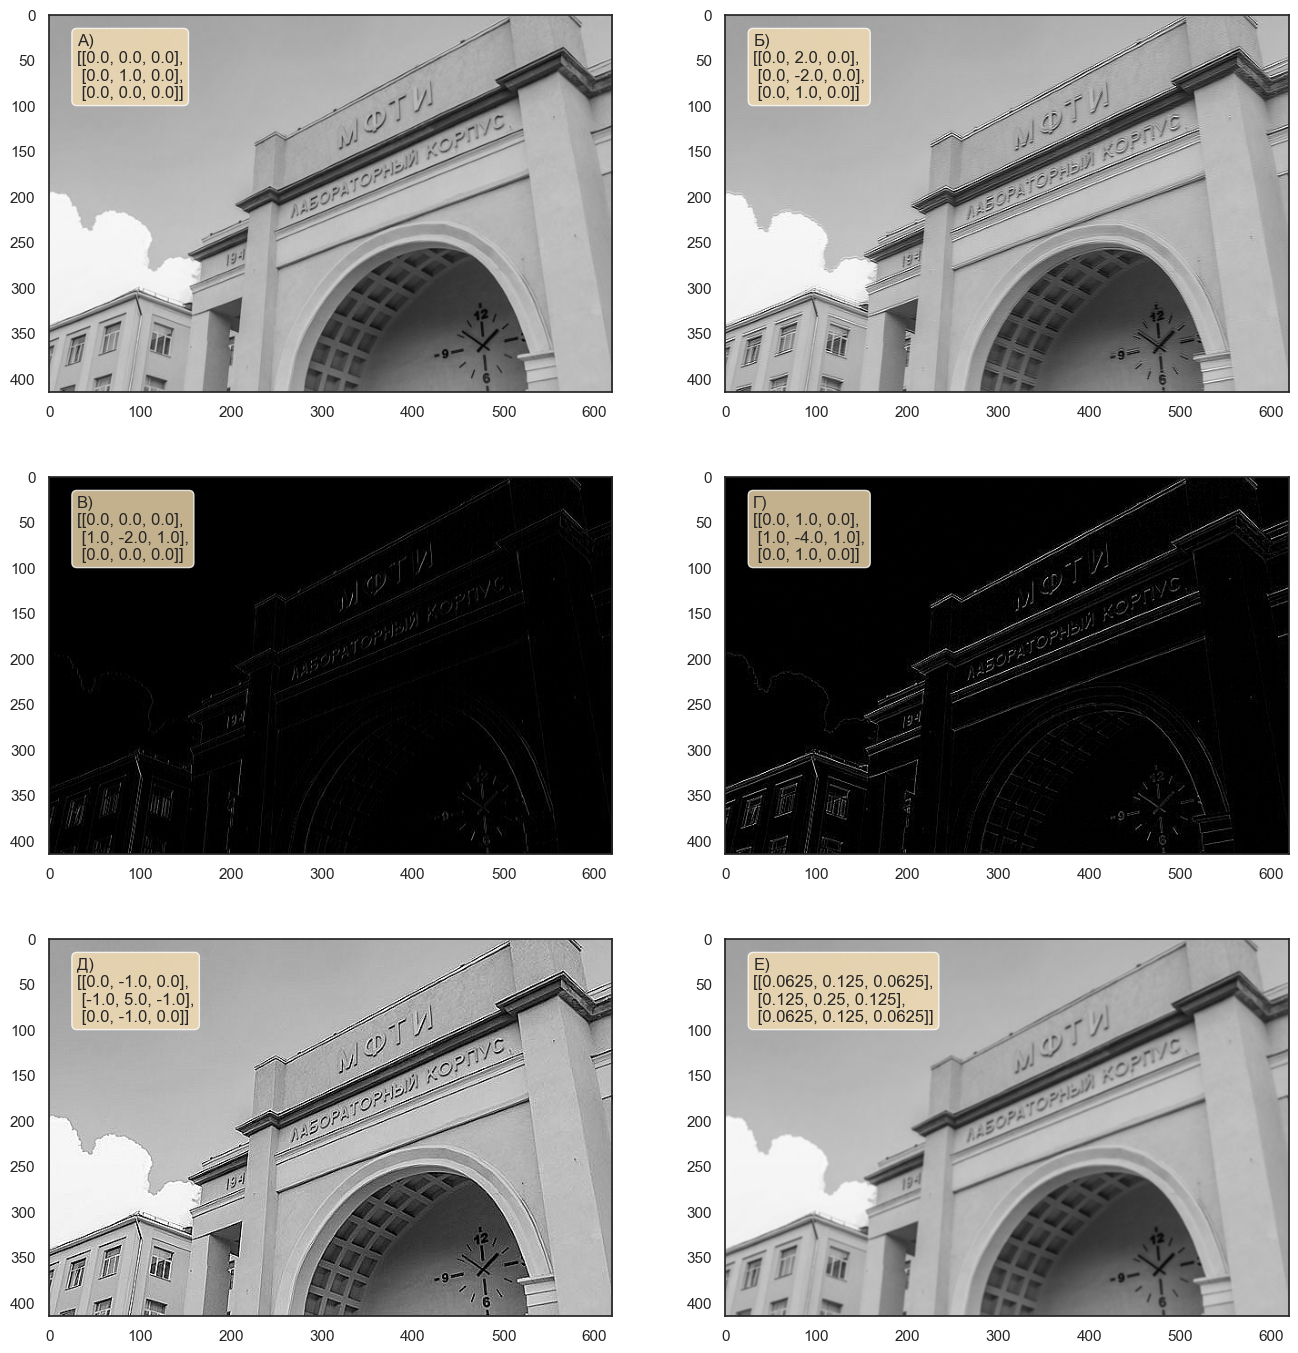

In [39]:
from itertools import chain
from pprint import pformat
from matplotlib.axes import Axes

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16, 17), squeeze=True)
for (name, kernel_tensor), ax in zip(convolutions.items(), chain(*axs)):
    ax: Axes
    # print(name, ax)

    result = F.conv2d(img_t, kernel_tensor)[0]
    result_np = result.permute(1, 2, 0).numpy() / 256 / 3
    ax.imshow(result_np)
    ax.text(
        0.05,
        0.95,
        f"{name})\n" + pformat(kernel_tensor[0][0].numpy().tolist(), width=30),
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8),
        verticalalignment="top",
        transform=ax.transAxes,
    )

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

1) Е
2) Д
3) А
4) В
5) Г
6) Б


### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [40]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)  # YOUR CODE
        self.conv2 = nn.Conv2d(6, 16, 3)  # YOUR CODE
        self.pool2 = nn.MaxPool2d(2,2)  # YOUR CODE
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # YOUR CODE
        self.fc2 = nn.Linear(120, 84)  # YOUR CODE
        self.fc3 = nn.Linear(84, 10)  # YOUR CODE

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)  # YOUR CODE. Apply layers created in __init__.
        x = nn.functional.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)

        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.fc3(x)
        return x

In [41]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [42]:
accuracy = train_model(
    model=model,
    loaders=loaders,
    criterion=criterion,
    optimizer=optimizer,
    max_epochs=10,
)

Epoch: 1
Loader: train. Accuracy: 0.8675


Loader: valid. Accuracy: 0.9538


Epoch: 2
Loader: train. Accuracy: 0.9617833333333333


Loader: valid. Accuracy: 0.9712


Epoch: 3
Loader: train. Accuracy: 0.97485


Loader: valid. Accuracy: 0.9788


Epoch: 4
Loader: train. Accuracy: 0.9813333333333333


Loader: valid. Accuracy: 0.9819


Epoch: 5
Loader: train. Accuracy: 0.9853


Loader: valid. Accuracy: 0.9845


Epoch: 6
Loader: train. Accuracy: 0.9873166666666666


Loader: valid. Accuracy: 0.9849


Epoch: 7
Loader: train. Accuracy: 0.9889666666666667


Loader: valid. Accuracy: 0.9846


Epoch: 8
Loader: train. Accuracy: 0.9904166666666666


Loader: valid. Accuracy: 0.9847


Epoch: 9
Loader: train. Accuracy: 0.9922333333333333


Loader: valid. Accuracy: 0.985


Epoch: 10
Loader: train. Accuracy: 0.9935166666666667


Loader: valid. Accuracy: 0.9853


In [43]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

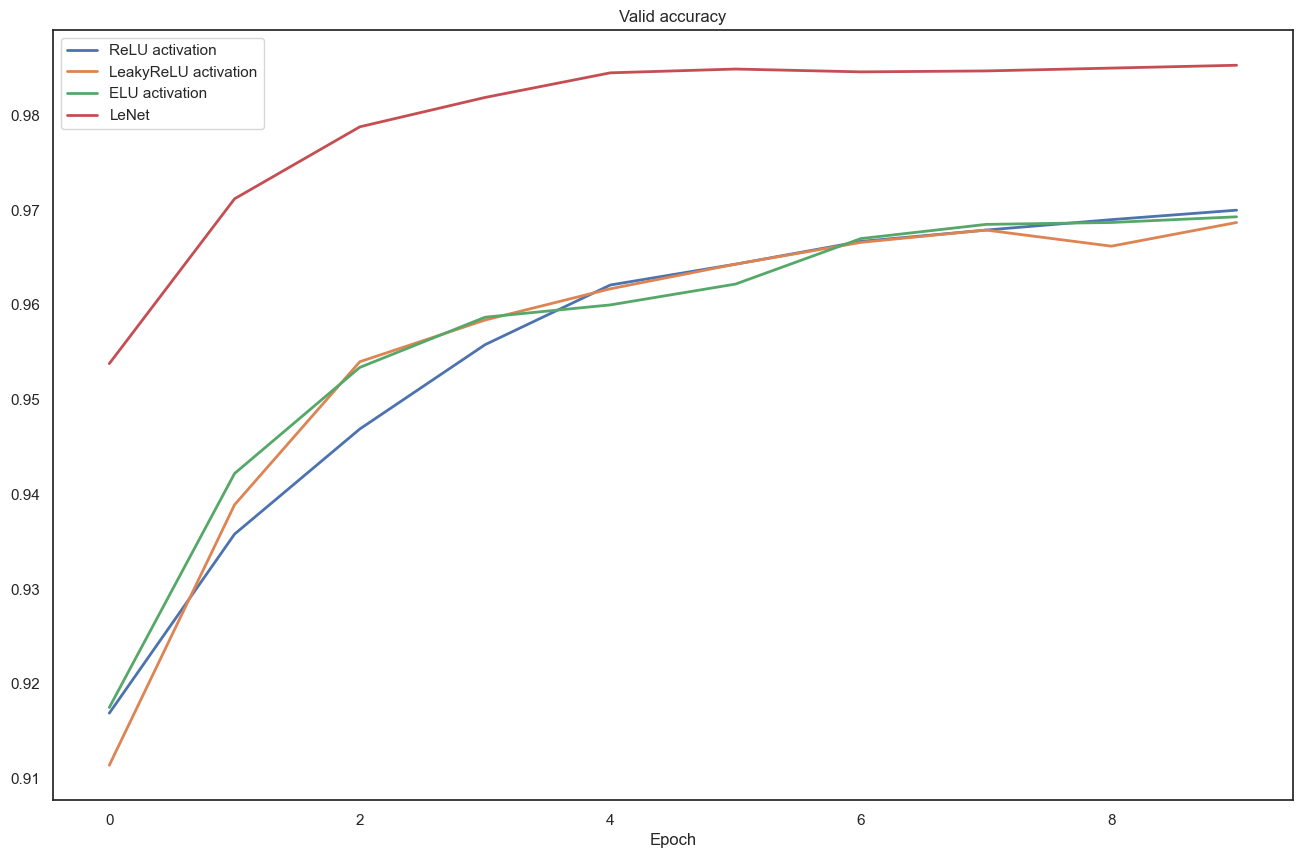

In [44]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy["valid"], label="ReLU activation", linewidth=2)
plt.plot(
    range(max_epochs), leaky_relu_accuracy["valid"], label="LeakyReLU activation", linewidth=2
)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99